In [30]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.merit import calculate_merit
import matplotlib.pyplot as plt

# Initialize
wls = np.linspace(500, 1000, 500)
inc_ang = 60.


def plot_film(f: FilmSimple):
    f.add_spec_param(inc_ang, wls)
    spectrum_before_sub = f.get_spec()
    spectrum_before_sub.calculate() # compile cuda kernel func
    # plot_spectrum(spectrum_before_sub)
np.random.seed(1)
f = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(200) * 30)
plot_film(f)

In [60]:
f_sub1 = copy.deepcopy(f)



def equal_optical_thickness(f: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            d[i - 1] += optical_ratio * d[i] + d[i + 1]
            d = np.delete(d, [i, i + 1])
            i -= 1
            count += 1
        i += 1
    f.update_d(d)
    return count

def substitute_search(f: FilmSimple):
    d = f.get_d()

d_mins_1 = np.linspace(0, 10, 100)
merits_1 = []
for d_min in d_mins_1:
    count = equal_optical_thickness(f_sub1, d_min)
    merits_1.append(calculate_merit(f, f_sub1))
    # print(merits[-1], "min d:", d_min, 'and', count, "layers deleted")




C:\Users\rfeng6\AppData\Local\Temp\ipykernel_20268\698869181.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += optical_ratio * d[i] + d[i + 1]


In [ ]:
def search_ot_substitution(f: FilmSimple, f_origin: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    ratios = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            m = calculate_merit(f, f_origin)

            for r in np.linspace(0, d_min * 10, 10):
                d_tmp = d.copy()
                # substitute
                d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]
                d_tmp = np.delete(d_tmp, [i, i + 1])

                f.update_d(d_tmp)
                m = calculate_merit(f, f_origin)
                if r == 0. or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d_tmp.copy()
                    best_r = r
            d = best_d
            ratios.append(best_r)
            count += 1

            i -= 1
        i += 1
    f.update_d(d)
    return count, ratios

d_mins_2 = np.linspace(0, 10, 100)
merits_2 = []
# takes about 10 min to run
for d_min in d_mins_2:
    f_sub2 = copy.deepcopy(f)
    count = search_ot_substitution(f_sub2, f, d_min)
    print(count)
    merits_2.append(calculate_merit(f, f_sub2))

fig, ax = plt.subplots(1, 1)
ax.plot(d_mins_1, merits_1, label='equal OT sub')
ax.plot(d_mins_2, merits_2, label='search OT sub')

ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_ylabel('difference in RMS')
ax.legend()

(0, [])
(2, [1.0101010101010102, 1.0101010101010102])
(2, [2.0202020202020203, 2.0202020202020203])
(2, [3.0303030303030303, 3.0303030303030303])
(3, [4.040404040404041, 4.040404040404041, 4.040404040404041])
(5, [5.050505050505051, 5.050505050505051, 5.050505050505051, 5.050505050505051, 0.5050505050505051])
(10, [6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 6.0606060606060606, 0.6060606060606061])
(10, [7.070707070707071, 7.070707070707071, 7.070707070707071, 7.070707070707071, 7.070707070707071, 7.070707070707071, 7.070707070707071, 7.070707070707071, 7.070707070707071, 0.7070707070707071])
(11, [8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 8.080808080808081, 0.8080808080808081])
(13, [9.09090909090909, 9.09090909090909, 0.9090909090909091, 9.090

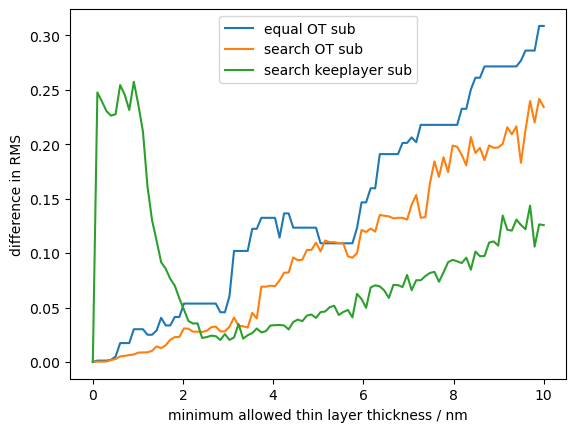

In [72]:
def search_keeplayer_substitution(f: FilmSimple, f_origin: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    ratios = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]

            for r in np.linspace(d_min, d_min * 10, 10):
                d_iminus1_tmp = d[i - 1]

                d[i - 1] = r

                f.update_d(d)
                m = calculate_merit(f, f_origin)
                # print(m)
                if r == d_min or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d.copy()
                    best_r = r
                
                d[i - 1] = d_iminus1_tmp # restore to search for others
            d = best_d
            ratios.append(best_r)
            count += 1

        i += 1
    f.update_d(d)
    return count, ratios

d_mins_3 = np.linspace(0, 10, 100)
merits_3 = []

for d_min in d_mins_2:
    f_sub3 = copy.deepcopy(f)
    count = search_keeplayer_substitution(f_sub3, f, d_min)
    print(count)
    merits_3.append(calculate_merit(f, f_sub3))

fig, ax = plt.subplots(1, 1)
ax.plot(d_mins_1, merits_1, label='equal OT sub')
ax.plot(d_mins_2, merits_2, label='search OT sub')
ax.plot(d_mins_3, merits_3, label='search keeplayer sub')

ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_ylabel('difference in RMS')
ax.legend()